# Color Extraction with PIL

In [1]:
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import glob

In [2]:
rgb_cols = ['r','g','b']

In [16]:
# img_dir = "images/*.*"
img_dir = "../images/*.jpg"
image_file_names = glob.glob(img_dir)
LIB = pd.DataFrame({'path':image_file_names})
LIB.index.name = 'img_id'

In [17]:
def get_main_colors_df(pixels, n_colors = 10):
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    my_df = pd.DataFrame(dominant_colors, columns=rgb_cols)
    my_df['n'] = pd.Series(kmeans.labels_).value_counts()
    return my_df

In [5]:
def plot_colors_df(my_df, title=None):
    w = len(my_df)
    plt.figure(figsize=(w, 2))
    plt.imshow([my_df[rgb_cols].values])
    plt.axis('off')
    plt.title(title)
    plt.show()

In [18]:
def show_lib():
    for idx, row in LIB.iterrows():
        
        my_img_file = row.path
        my_img = Image.open(my_img_file)
        my_img.thumbnail((100, 100))
        plt.imshow(my_img)

        my_img_data = my_img.getdata()
        my_img_df = pd.DataFrame(list(my_img_data), columns=rgb_cols)
        my_colors_df = get_main_colors_df(my_img_df)
        title = row.path.split("/")[1].split(".")[0].replace("-", " ").upper()
        plot_colors_df(my_colors_df, title=title)

        plt.show()

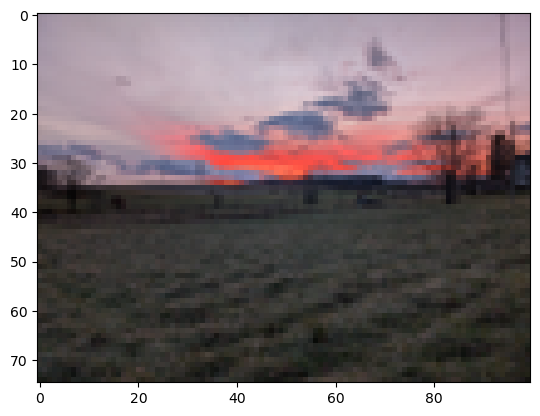

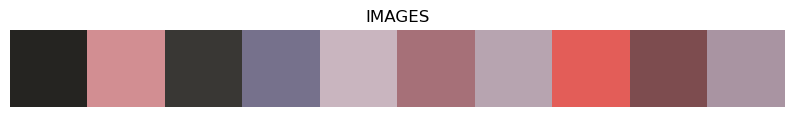

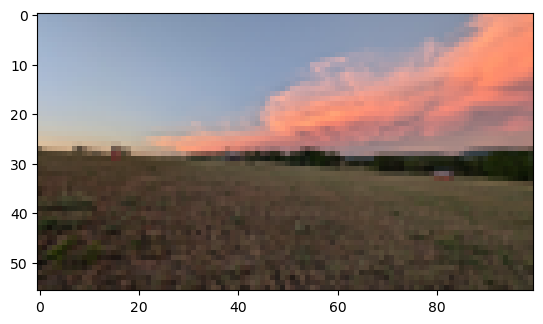

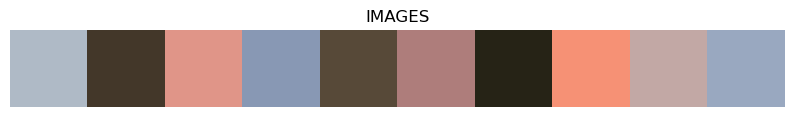

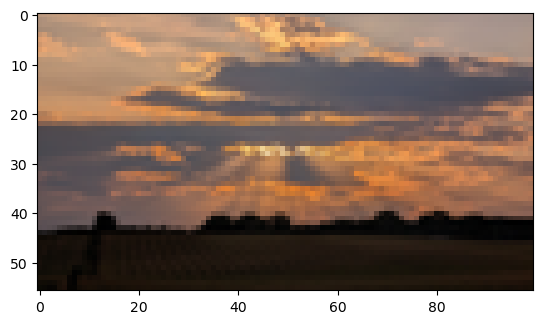

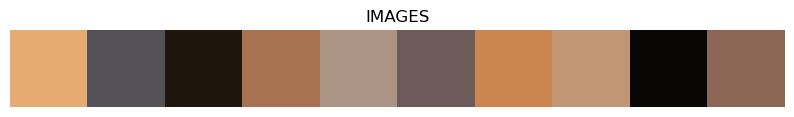

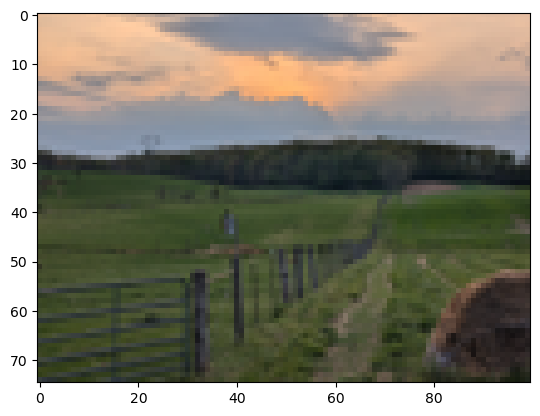

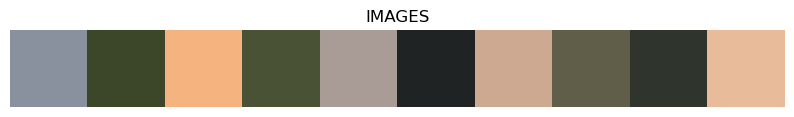

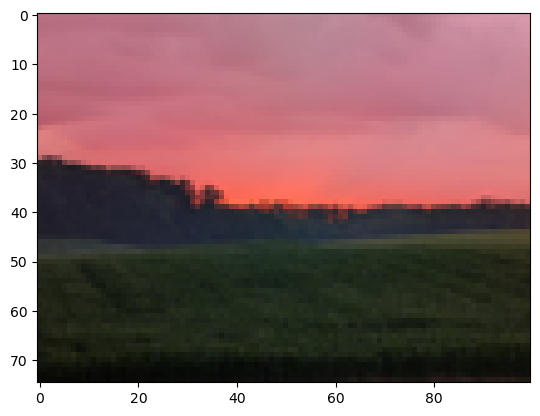

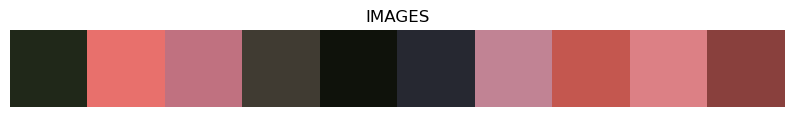

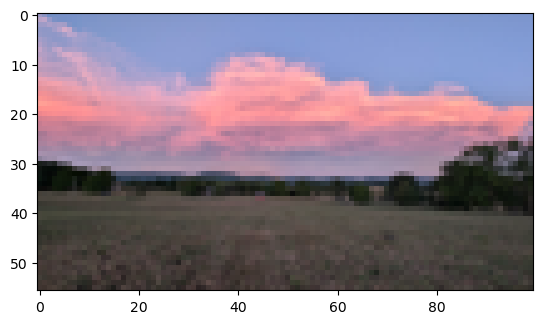

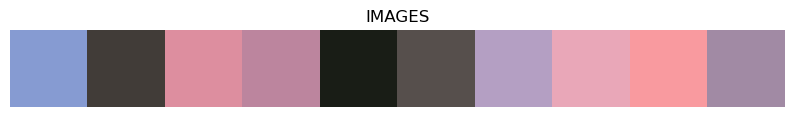

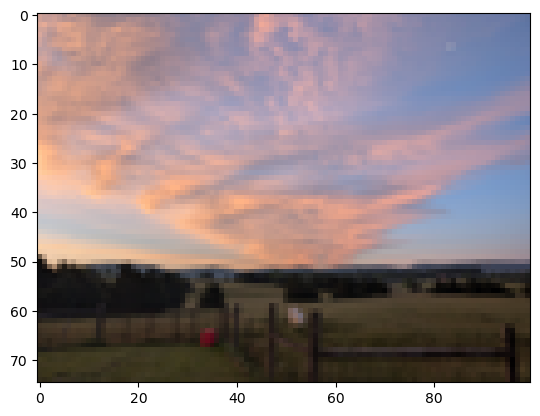

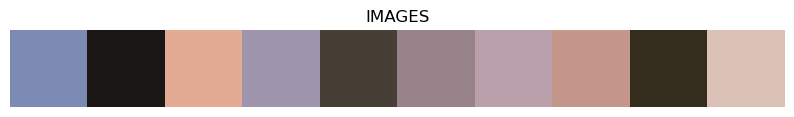

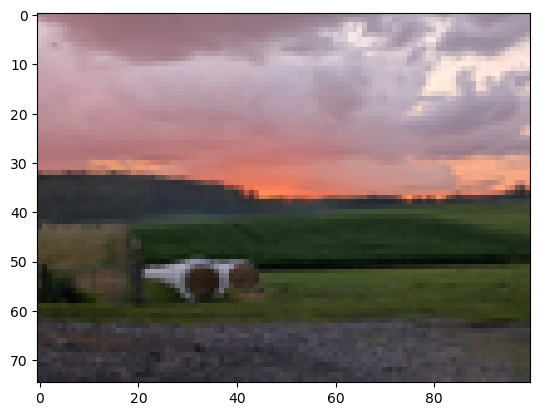

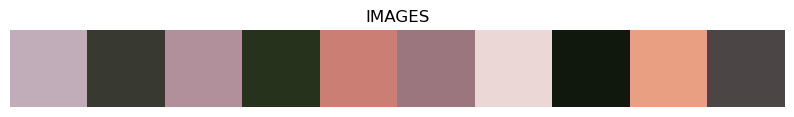

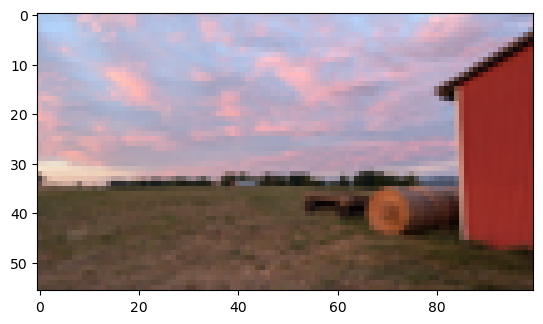

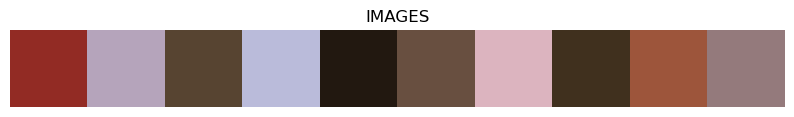

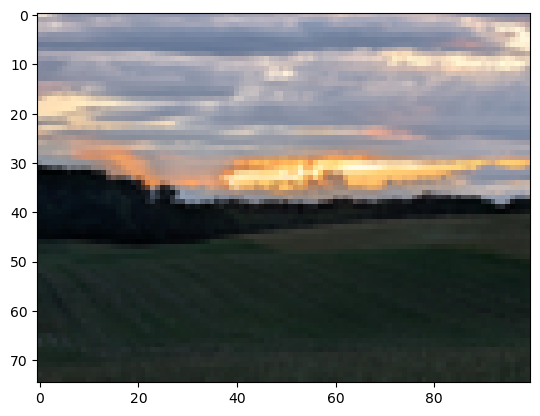

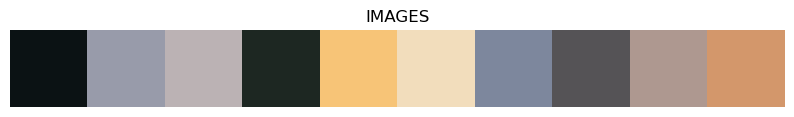

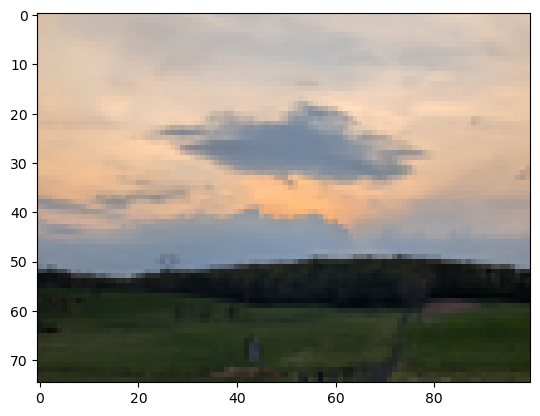

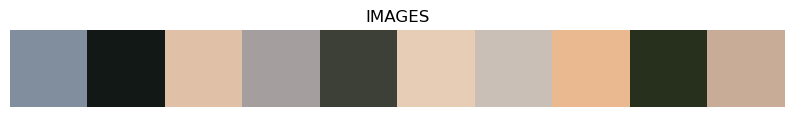

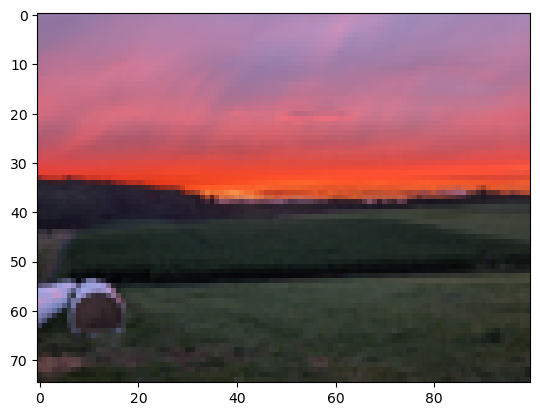

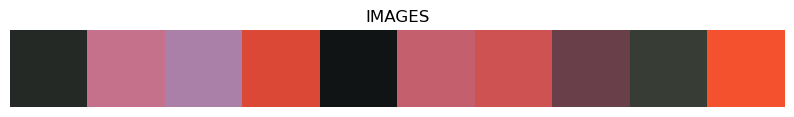

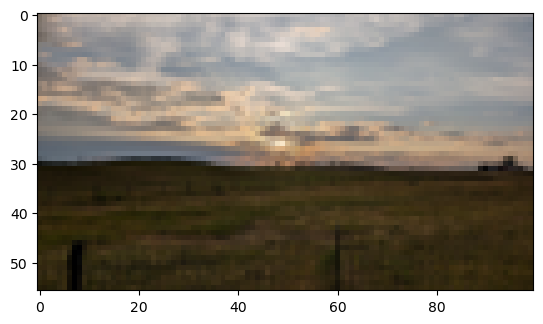

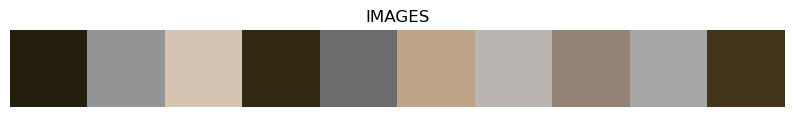

In [19]:
show_lib()

# Create IMAGES

In [7]:
img_size = (32, 32)
all_images = []
for idx, row in LIB.iterrows():
    img_file = row.path
    img = Image.open(img_file)
    img.thumbnail(img_size)
    df = pd.DataFrame(list(img.getdata()), columns=rgb_cols)
    df['rgb'] = (df.values / 255.).tolist()
    all_images.append(df)
IMAGES = pd.concat(all_images, keys=range(len(all_images)))
IMAGES.index.names = ['img_id', 'pixel_id']

In [8]:
IMAGES

r    g    b  \
img_id pixel_id                  
0      0         159  145  162   
       1         167  151  166   
       2         168  153  165   
       3         169  154  165   
       4         171  157  167   
...              ...  ...  ...   
12     571        53   42   15   
       572        51   40   15   
       573        50   39   12   
       574        47   37   11   
       575        45   35   11   

                                                               rgb  
img_id pixel_id                                                     
0      0         [0.6235294117647059, 0.5686274509803921, 0.635...  
       1         [0.6549019607843137, 0.592156862745098, 0.6509...  
       2             [0.6588235294117647, 0.6, 0.6470588235294118]  
       3         [0.6627450980392157, 0.6039215686274509, 0.647...  
       4         [0.6705882352941176, 0.615686274509804, 0.6549...  
...                                                            ...  
12     571       [0.20784313725490197, 0.16470588235294117, 0.0...  
       572         [0.2, 0.1568627450980392, 0.058823529411764705]  
       573       [0.19607843137254902, 0.15294117647058825, 0.0...  
       574       [0.1843137254901961, 0.1450980392156863, 0.043...  
       575       [0.17647058823529413, 0.13725490196078433, 0.0...  

[9024 rows x 4 columns]

# Extract COLORS

In [9]:
group_col = 'img_id'

COLORS = IMAGES.groupby(group_col)[rgb_cols].apply(get_main_colors_df)
COLORS.index.names = [group_col, 'color_id']
COLORS['rgb'] = (COLORS[['r', 'g', 'b']].values / 255).tolist()
COLORS['logn'] = np.log(COLORS.n)
COLORS.head()

r    g    b    n  \
img_id color_id                       
0      0          36   35   31   90   
       1         185  163  175  110   
       2         134  116  137   36   
       3          60   57   55  145   
       4         194  117  123   25   

                                                               rgb      logn  
img_id color_id                                                               
0      0         [0.1411764705882353, 0.13725490196078433, 0.12...  4.499810  
       1         [0.7254901960784313, 0.6392156862745098, 0.686...  4.700480  
       2         [0.5254901960784314, 0.4549019607843137, 0.537...  3.583519  
       3         [0.23529411764705882, 0.2235294117647059, 0.21...  4.976734  
       4         [0.7607843137254902, 0.4588235294117647, 0.482...  3.218876

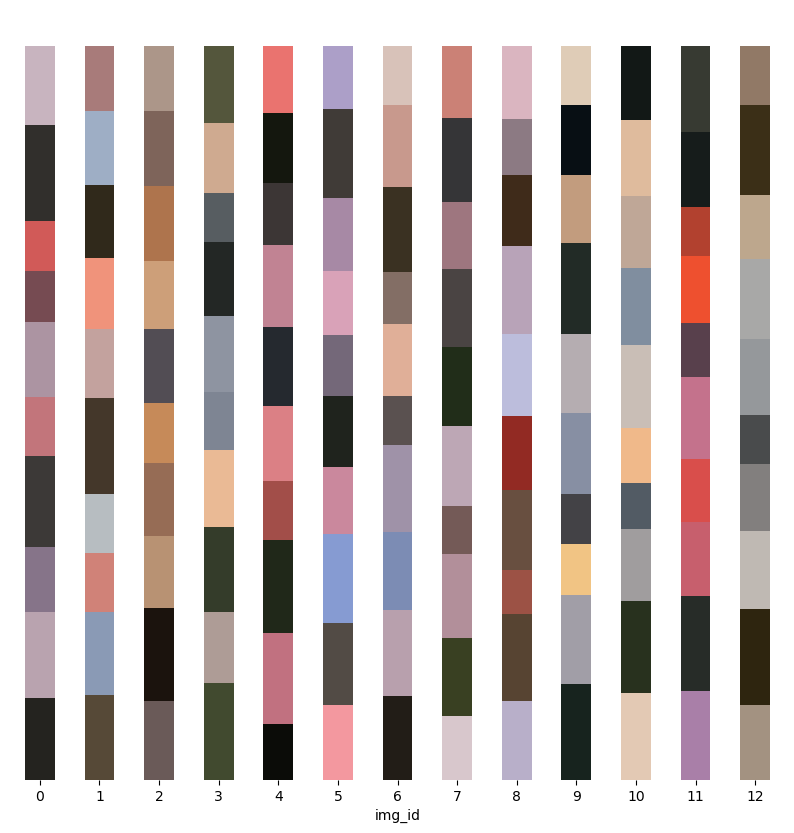

In [10]:
M_n = COLORS.logn.unstack()
M_p = (M_n.T / M_n.T.sum()).T
M_rgb = COLORS.rgb.unstack()

ax = M_p.plot.bar(stacked=True, legend=False, rot=0, figsize=(10, 10))

# Get all the bar patches
patches = ax.patches

# Calculate how many patches per image
n_images = M_p.shape[0]  # number of images (bars) 
# n_colors = M_p.shape[1]  # number of color segments

# Iterate through patches and apply colors
# There are n_images x n_colors patches (80)
for i, patch in enumerate(patches):
    
    # Determine which image and which color this patch belongs to
    color_idx = i // n_images  # which color segment (0-9)
    img_idx = i % n_images     # which image (0-7)
    
    # Get the RGB color for this specific combination
    rgb = M_rgb.loc[img_idx, color_idx]
    
    # Set the color
    patch.set_facecolor(rgb)

# Clean up the image
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.tick_params(left=False)

plt.show()

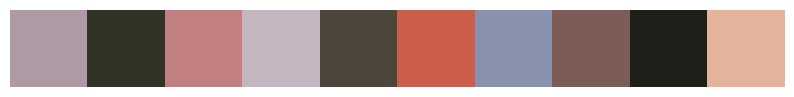

In [11]:
plot_colors_df(get_main_colors_df(IMAGES[rgb_cols].reset_index(drop=True), 10))